Ref: https://youtu.be/iFADsRDJhDM?feature=shared

# Inference with CPU, CUDA and TensorRT

### step1: load a pre-trained neural network

In [1]:
import torch
from torchvision import models, transforms

# using cpu
#model = models.resnet50(pretrained=True)

# using gpu
model = models.resnet50(pretrained=True).to("cuda")

/home/jaykumaran/miniconda3/envs/torch_2x/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jaykumaran/miniconda3/envs/torch_2x/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### step 2: load an example image for predition

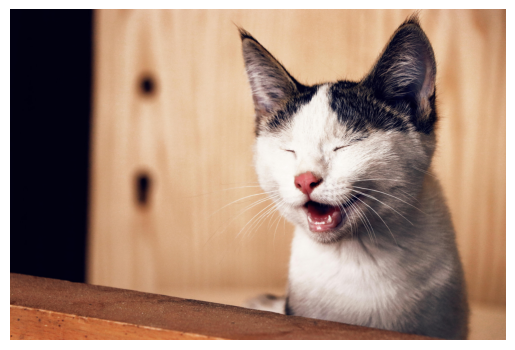

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("cat.jpg")
plt.axis('off')
plt.imshow(img)
plt.show()

### step 3: transform example image (pre-processing)

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

img = transform(img)
print(img.shape)

torch.Size([3, 224, 224])


### step 4: set a batch size to example image

In [4]:
# using cpu
#img_batch = torch.unsqueeze(img, 0)

#using gpu
img_batch = torch.unsqueeze(img, 0).to("cuda")
img_batch.shape

torch.Size([1, 3, 224, 224])

### step 5: make a prediction and get probabilities for each class

In [5]:
model.eval()
with torch.no_grad():
    outputs = model(img_batch)
    
prob = torch.nn.functional.softmax(outputs[0], dim=0)
# prob.argmax()

### step 6: get the names of all available ImageNet classes
source: https://github.com/pytorch/hub/blob/master/imagenet_classes.txt

In [6]:
import pandas as pd

categories = pd.read_csv('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt', header=None)

### step 7: extract top 5 probabilities and map them to the appropriate class name

In [7]:
topk = 5

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = categories[0][int(classes[i])]
    print("%{} {}".format(int(probability*100), class_label))

%61 Egyptian cat
%25 lynx
%4 Siamese cat
%3 tabby
%1 tiger cat


### step 8: define a speed test benchmark function & adjust it

source: ResNet50_example.ipynb
<br>
or: https://github.com/NVIDIA/Torch-TensorRT/blob/master/notebooks/Resnet50-example.ipynb

In [8]:
#copy from TRT
import time
import numpy as np

import torch.backends.cudnn as cudnn
# for entire jupyter or script session
cudnn.benchmark = True

def benchmark(model, device="cuda", input_shape=(32, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=100):
    model = model.to(device)
    input_data = torch.randn(input_shape)
    input_data = input_data.to(device)
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

### step 9: find out CPU model speed benchmarks

In [49]:
# #CPU benchmarks
# benchmark(model, device="cpu")

### step 10: find out CUDA model speed benchmarks

In [9]:
#CUDA benchmarks
model = model.to("cuda")
benchmark(model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 79.28 ms
Iteration 20/100, ave batch time 79.38 ms
Iteration 30/100, ave batch time 79.37 ms
Iteration 40/100, ave batch time 79.40 ms
Iteration 50/100, ave batch time 79.38 ms
Iteration 60/100, ave batch time 79.44 ms
Iteration 70/100, ave batch time 79.49 ms
Iteration 80/100, ave batch time 79.52 ms
Iteration 90/100, ave batch time 79.51 ms
Iteration 100/100, ave batch time 79.47 ms
Input shape: torch.Size([32, 3, 224, 224])
Output features size: torch.Size([32, 1000])
Average batch time: 79.47 ms


### step 11: trace and compile CUDA model into a TensorRT model

In [9]:
traced_model = torch.jit.trace(model, [torch.randn((32, 3, 224, 224)).to("cuda")])

# Print the graph
print(traced_model.graph)

graph(%self.1 : __torch__.torchvision.models.resnet.ResNet,
      %x.1 : Float(32, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0)):
  %fc : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc"](%self.1)
  %avgpool : __torch__.torch.nn.modules.pooling.AdaptiveAvgPool2d = prim::GetAttr[name="avgpool"](%self.1)
  %layer4 : __torch__.torch.nn.modules.container.___torch_mangle_141.Sequential = prim::GetAttr[name="layer4"](%self.1)
  %layer3 : __torch__.torch.nn.modules.container.___torch_mangle_113.Sequential = prim::GetAttr[name="layer3"](%self.1)
  %layer2 : __torch__.torch.nn.modules.container.___torch_mangle_61.Sequential = prim::GetAttr[name="layer2"](%self.1)
  %layer1 : __torch__.torch.nn.modules.container.___torch_mangle_25.Sequential = prim::GetAttr[name="layer1"](%self.1)
  %maxpool : __torch__.torch.nn.modules.pooling.MaxPool2d = prim::GetAttr[name="maxpool"](%self.1)
  %relu.1 : __torch__.torch.nn.modules.activation.ReLU = prim::GetAt

In [10]:
print(traced_model.code)

def forward(self,
    x: Tensor) -> Tensor:
  fc = self.fc
  avgpool = self.avgpool
  layer4 = self.layer4
  layer3 = self.layer3
  layer2 = self.layer2
  layer1 = self.layer1
  maxpool = self.maxpool
  relu = self.relu
  bn1 = self.bn1
  conv1 = self.conv1
  _0 = (relu).forward((bn1).forward((conv1).forward(x, ), ), )
  _1 = (layer1).forward((maxpool).forward(_0, ), )
  _2 = (layer3).forward((layer2).forward(_1, ), )
  _3 = (avgpool).forward((layer4).forward(_2, ), )
  input = torch.flatten(_3, 1)
  return (fc).forward(input, )



In [11]:
with torch.no_grad():
    _ = traced_model(torch.randn((32, 3, 224, 224)).cuda())

# Print the optimized graph
print(torch.jit.last_executed_optimized_graph())


graph(%self.1 : __torch__.torchvision.models.resnet.ResNet,
      %x.1 : Tensor):
  %12 : int = prim::Constant[value=-1]() # /home/jaykumaran/miniconda3/envs/torch_2x/lib/python3.10/site-packages/torchvision/models/resnet.py:279:0
  %11 : float = prim::Constant[value=0.10000000000000001](), scope: __module.bn1 # /home/jaykumaran/miniconda3/envs/torch_2x/lib/python3.10/site-packages/torch/nn/functional.py:2822:0
  %10 : float = prim::Constant[value=1.0000000000000001e-05](), scope: __module.bn1 # /home/jaykumaran/miniconda3/envs/torch_2x/lib/python3.10/site-packages/torch/nn/functional.py:2822:0
  %9 : NoneType = prim::Constant(), scope: __module.conv1
  %8 : int = prim::Constant[value=1](), scope: __module.conv1 # /home/jaykumaran/miniconda3/envs/torch_2x/lib/python3.10/site-packages/torch/nn/modules/conv.py:549:0
  %7 : bool = prim::Constant[value=0](), scope: __module.conv1 # /home/jaykumaran/miniconda3/envs/torch_2x/lib/python3.10/site-packages/torch/nn/modules/conv.py:549:0
  %6 : 

In [ ]:
!pip install torchviz -q

# Run in bash
# !sudo apt install graphviz


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [14]:
from torchviz import make_dot

input_tensor = torch.randn((32, 3, 224, 224)).cuda()
output = traced_model(input_tensor)

# Generate and save the computation graph
dot = make_dot(output, params=dict(traced_model.named_parameters()))
dot.render("traced_model_graph", format="png")  # Saves as PNG



'traced_model_graph.png'

In [14]:
import torch_tensorrt

trt_model = torch_tensorrt.compile(
    traced_model,
    ir = 'torchscript',
    inputs = [torch_tensorrt.Input((32, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = {torch.float32}
)

### step 12: find out TensorRT model speed benchmarks

In [23]:
benchmark(trt_model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 36.11 ms
Iteration 20/100, ave batch time 36.25 ms
Iteration 30/100, ave batch time 36.22 ms
Iteration 40/100, ave batch time 36.27 ms
Iteration 50/100, ave batch time 36.29 ms
Iteration 60/100, ave batch time 36.28 ms
Iteration 70/100, ave batch time 36.33 ms
Iteration 80/100, ave batch time 36.34 ms
Iteration 90/100, ave batch time 36.36 ms
Iteration 100/100, ave batch time 36.40 ms
Input shape: torch.Size([32, 3, 224, 224])
Output features size: torch.Size([32, 1000])
Average batch time: 36.40 ms


### step 13: make a prediction with the TensorRT model

In [15]:
trt_model.eval()


### BAD APPROACH ##############################################################
# Ensure the input has batch size 32 (duplicate if necessary)
if img_batch.shape[0] != 32:
    padding_needed = 32 - img_batch.shape[0]  # Compute required padding
    img_batch = torch.cat([img_batch] * 32, dim=0)  # Duplicate images

#############################################################################


with torch.no_grad():
    
    outputs = trt_model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = categories[0][int(classes[i])]
    print("%{} {}".format(int(probability*100), class_label))

%61 Egyptian cat
%25 lynx
%4 Siamese cat
%3 tabby
%1 tiger cat
